In [2]:
import glob
import pickle
import random

from keyrover import *
from keyrover.homography import *

In [3]:
with open("blender/camera_data.bin", "rb") as f:
    camera_data = pickle.load(f)

datasets/segmentation/v4-nofisheye/keyboard_3633_1.jpg
tensor([[ 0.3233,  0.0438,  0.2450, -0.0514, -0.8090,  2.1525]], device='mps:0')


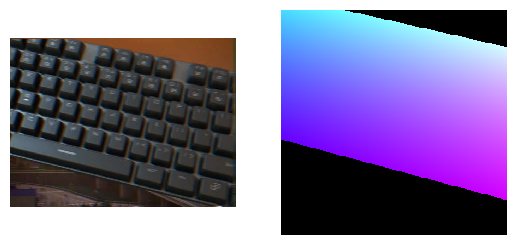

In [25]:
files = glob.glob(f"{SEGMENTATION_DATASET}/*")
path = random.choice(files)
print(path)

img = cv2.imread(path)

i = int(path.split("_")[1]) - 1
location = camera_data["location"][i]
rotation = camera_data["rotation"][i]

camera = torch.tensor([[*rotation, *location]], device=device, dtype=torch.float32)
print(camera)
texcoords = prediction_to_texture_coordinates(camera)

t = texcoords[0]
t[2] += 1
t[2] /= t[2].max() / 2
t[2] -= 1

imshow(img, t)